# Pokemon Legendary Prediction

#### By Nattapat Yuvasuta (Nut) KMUTT

In [1]:
import keras
import pandas as pd
from keras import models
from keras import layers
from keras import optimizers
from keras import backend as K
from keras.layers import Dropout
from keras import callbacks
from keras.optimizers import SGD

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Nz-zero\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Load Data

In [2]:
poke = pd.read_csv("Pokemon.csv")

In [3]:
poke.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
x = poke.select_dtypes(['object','bool']).columns
n = 0
for i in x:
    print("---> %s"%i)
    t = poke[i].value_counts()
    s  = poke[i].value_counts().sum()
    M = max(t)
    B = (M/s)*100
    print(B)
    if B > 75.0:
        print("unbalance")
        n = n+1
    else:
        print("balance")
print(n)

---> Name
0.125
balance
---> Type 1
14.000000000000002
balance
---> Type 2
23.42995169082126
balance
---> Legendary
91.875
unbalance
1


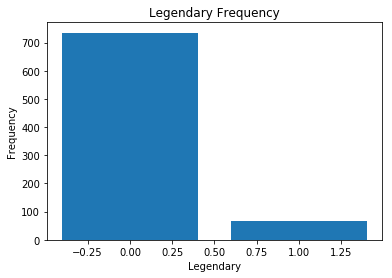

In [5]:
classes = poke['Legendary'].values
unique, counts = np.unique(classes, return_counts=True)

plt.bar(unique,counts)
plt.title('Legendary Frequency')
plt.xlabel('Legendary')
plt.ylabel('Frequency')
plt.show()

In [6]:
poke.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

## 2. Data Preprocessing

In [7]:
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class

def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()


In [8]:
poke_1 = poke.drop(columns=['#','Name','Generation','Type 1','Type 2'])

In [9]:
poke_1['Total'] = poke_1['Total']/(np.max(poke_1['Total'])/1.0)
poke_1['HP'] = poke_1['HP']/(np.max(poke_1['HP'])/1.0)
poke_1['Attack'] = poke_1['Attack']/(np.max(poke_1['Attack'])/1.0)
poke_1['Defense'] = poke_1['Defense']/(np.max(poke_1['Defense'])/1.0)
poke_1['Sp. Atk'] = poke_1['Sp. Atk']/(np.max(poke_1['Sp. Atk'])/1.0)
poke_1['Sp. Def'] = poke_1['Sp. Def']/(np.max(poke_1['Sp. Def'])/1.0)
poke_1['Speed'] = poke_1['Speed']/(np.max(poke_1['Speed'])/1.0)

In [10]:
# poke_2 = pd.get_dummies(poke_1, columns = ['Type 1', 'Type 2'])
# poke_2.head()

In [11]:
codebook = {True: 1, False: 0}
poke_3 = poke_1.replace(codebook)
poke_3['Legendary']

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
770    0
771    0
772    0
773    0
774    0
775    0
776    0
777    0
778    0
779    0
780    0
781    0
782    0
783    0
784    0
785    0
786    0
787    0
788    0
789    0
790    0
791    0
792    1
793    1
794    1
795    1
796    1
797    1
798    1
799    1
Name: Legendary, Length: 800, dtype: int64

In [12]:
trainData_X = poke_3.drop('Legendary',axis = 1) #remove the predictor
trainData_Y = poke_3.Legendary #set the predictor

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainData_X, trainData_Y,
test_size = 0.4, random_state=1) #divide training and testing data by using hold-out method

In [13]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(trainData_X, trainData_Y)

In [14]:
X_resampled.shape

(1470, 7)

In [21]:
y_resampled.resize((1470,1))

In [22]:
y_resampled.shape

(1470, 1)

In [23]:
trainData_X.shape

(800, 7)

In [24]:
trainData_X.shape

(800, 7)

In [25]:
print('Train_set Feature shape: %s'%str(X_train.shape))
print('Train_set Label type: %s'%str(y_train.shape))
print('Test_set Feature shape: %s'%str(X_test.shape))
print('Test_set Label type: %s'%str(y_test.shape))

Train_set Feature shape: (480, 7)
Train_set Label type: (480,)
Test_set Feature shape: (320, 7)
Test_set Label type: (320,)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled,y_resampled,test_size=0.3,stratify = y_resampled, random_state=1)

## 3. Build Network

#### Neural Network

In [28]:
network = models.Sequential()

In [29]:
network.add(layers.Dense(512, activation='relu',input_shape=(7,)))
network.add(Dropout(0.8))
network.add(layers.Dense(256, activation='relu'))
network.add(Dropout(0.8))
network.add(layers.Dense(2, activation='softmax'))

In [30]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 135,938
Trainable params: 135,938
Non-trainable params: 0
_________________________________________________________________


In [31]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=5)
# ]
checkpointer = ModelCheckpoint(filepath="poke_weight.hdf5", verbose=1, save_best_only=True)
network.compile(optimizer=SGD(lr=0.01),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']
               )

In [32]:
history = network.fit(X_train,y_train,batch_size=32,epochs=400,validation_data=(X_val,y_val),callbacks=[checkpointer])

Train on 1029 samples, validate on 441 samples
Epoch 1/400
1029/1029 [==============================] - 3s 3ms/step - loss: 0.7112 - acc: 0.4985 - val_loss: 0.6756 - val_acc: 0.5011

Epoch 00001: val_loss improved from inf to 0.67558, saving model to poke_weight.hdf5
Epoch 2/400
1029/1029 [==============================] - 0s 172us/step - loss: 0.7005 - acc: 0.5121 - val_loss: 0.6689 - val_acc: 0.5011

Epoch 00002: val_loss improved from 0.67558 to 0.66890, saving model to poke_weight.hdf5
Epoch 3/400
1029/1029 [==============================] - 0s 141us/step - loss: 0.6928 - acc: 0.5219 - val_loss: 0.6628 - val_acc: 0.5057

Epoch 00003: val_loss improved from 0.66890 to 0.66281, saving model to poke_weight.hdf5
Epoch 4/400
1029/1029 [==============================] - 0s 183us/step - loss: 0.6836 - acc: 0.5345 - val_loss: 0.6568 - val_acc: 0.5306

Epoch 00004: val_loss improved from 0.66281 to 0.65677, saving model to poke_weight.hdf5
Epoch 5/400
1029/1029 [============================

Epoch 37/400
1029/1029 [==============================] - 0s 148us/step - loss: 0.4230 - acc: 0.8397 - val_loss: 0.4040 - val_acc: 0.8957

Epoch 00037: val_loss improved from 0.40943 to 0.40399, saving model to poke_weight.hdf5
Epoch 38/400
1029/1029 [==============================] - 0s 130us/step - loss: 0.4205 - acc: 0.8649 - val_loss: 0.3945 - val_acc: 0.8980

Epoch 00038: val_loss improved from 0.40399 to 0.39453, saving model to poke_weight.hdf5
Epoch 39/400
1029/1029 [==============================] - 0s 148us/step - loss: 0.4169 - acc: 0.8367 - val_loss: 0.3871 - val_acc: 0.9070

Epoch 00039: val_loss improved from 0.39453 to 0.38706, saving model to poke_weight.hdf5
Epoch 40/400
1029/1029 [==============================] - 0s 145us/step - loss: 0.4186 - acc: 0.8260 - val_loss: 0.3805 - val_acc: 0.9184

Epoch 00040: val_loss improved from 0.38706 to 0.38051, saving model to poke_weight.hdf5
Epoch 41/400
1029/1029 [==============================] - 0s 132us/step - loss: 0.4070 -

1029/1029 [==============================] - 0s 239us/step - loss: 0.3051 - acc: 0.8921 - val_loss: 0.2685 - val_acc: 0.9206

Epoch 00073: val_loss did not improve from 0.26751
Epoch 74/400
1029/1029 [==============================] - 0s 220us/step - loss: 0.2751 - acc: 0.9067 - val_loss: 0.2648 - val_acc: 0.9229

Epoch 00074: val_loss improved from 0.26751 to 0.26479, saving model to poke_weight.hdf5
Epoch 75/400
1029/1029 [==============================] - 0s 324us/step - loss: 0.2871 - acc: 0.9038 - val_loss: 0.2623 - val_acc: 0.9320

Epoch 00075: val_loss improved from 0.26479 to 0.26227, saving model to poke_weight.hdf5
Epoch 76/400
1029/1029 [==============================] - 0s 187us/step - loss: 0.2741 - acc: 0.8970 - val_loss: 0.2650 - val_acc: 0.9184

Epoch 00076: val_loss did not improve from 0.26227
Epoch 77/400
1029/1029 [==============================] - 0s 153us/step - loss: 0.2684 - acc: 0.9048 - val_loss: 0.2586 - val_acc: 0.9297

Epoch 00077: val_loss improved from 0.

1029/1029 [==============================] - 0s 149us/step - loss: 0.2414 - acc: 0.9174 - val_loss: 0.2341 - val_acc: 0.9252

Epoch 00111: val_loss did not improve from 0.22899
Epoch 112/400
1029/1029 [==============================] - 0s 139us/step - loss: 0.2319 - acc: 0.9145 - val_loss: 0.2289 - val_acc: 0.9478

Epoch 00112: val_loss improved from 0.22899 to 0.22893, saving model to poke_weight.hdf5
Epoch 113/400
1029/1029 [==============================] - 0s 128us/step - loss: 0.2382 - acc: 0.9145 - val_loss: 0.2313 - val_acc: 0.9433

Epoch 00113: val_loss did not improve from 0.22893
Epoch 114/400
1029/1029 [==============================] - 0s 131us/step - loss: 0.2405 - acc: 0.9164 - val_loss: 0.2346 - val_acc: 0.9365

Epoch 00114: val_loss did not improve from 0.22893
Epoch 115/400
1029/1029 [==============================] - 0s 141us/step - loss: 0.2313 - acc: 0.9174 - val_loss: 0.2257 - val_acc: 0.9501

Epoch 00115: val_loss improved from 0.22893 to 0.22570, saving model to 

1029/1029 [==============================] - 0s 144us/step - loss: 0.2290 - acc: 0.9320 - val_loss: 0.2185 - val_acc: 0.9501

Epoch 00151: val_loss did not improve from 0.21362
Epoch 152/400
1029/1029 [==============================] - 0s 153us/step - loss: 0.2068 - acc: 0.9261 - val_loss: 0.2134 - val_acc: 0.9524

Epoch 00152: val_loss improved from 0.21362 to 0.21338, saving model to poke_weight.hdf5
Epoch 153/400
1029/1029 [==============================] - 0s 208us/step - loss: 0.2105 - acc: 0.9359 - val_loss: 0.2119 - val_acc: 0.9524

Epoch 00153: val_loss improved from 0.21338 to 0.21189, saving model to poke_weight.hdf5
Epoch 154/400
1029/1029 [==============================] - 0s 194us/step - loss: 0.2179 - acc: 0.9310 - val_loss: 0.2205 - val_acc: 0.9456

Epoch 00154: val_loss did not improve from 0.21189
Epoch 155/400
1029/1029 [==============================] - 0s 165us/step - loss: 0.2007 - acc: 0.9388 - val_loss: 0.2171 - val_acc: 0.9501

Epoch 00155: val_loss did not impr

1029/1029 [==============================] - 0s 148us/step - loss: 0.1922 - acc: 0.9329 - val_loss: 0.2105 - val_acc: 0.9524

Epoch 00192: val_loss did not improve from 0.20663
Epoch 193/400
1029/1029 [==============================] - 0s 151us/step - loss: 0.2044 - acc: 0.9436 - val_loss: 0.2167 - val_acc: 0.9478

Epoch 00193: val_loss did not improve from 0.20663
Epoch 194/400
1029/1029 [==============================] - 0s 186us/step - loss: 0.2083 - acc: 0.9436 - val_loss: 0.2162 - val_acc: 0.9478

Epoch 00194: val_loss did not improve from 0.20663
Epoch 195/400
1029/1029 [==============================] - 0s 154us/step - loss: 0.2144 - acc: 0.9417 - val_loss: 0.2192 - val_acc: 0.9478

Epoch 00195: val_loss did not improve from 0.20663
Epoch 196/400
1029/1029 [==============================] - 0s 151us/step - loss: 0.1894 - acc: 0.9388 - val_loss: 0.2061 - val_acc: 0.9524

Epoch 00196: val_loss improved from 0.20663 to 0.20609, saving model to poke_weight.hdf5
Epoch 197/400
1029/10

1029/1029 [==============================] - 0s 147us/step - loss: 0.1867 - acc: 0.9446 - val_loss: 0.2032 - val_acc: 0.9546

Epoch 00233: val_loss did not improve from 0.20086
Epoch 234/400
1029/1029 [==============================] - 0s 148us/step - loss: 0.2033 - acc: 0.9261 - val_loss: 0.2010 - val_acc: 0.9546

Epoch 00234: val_loss did not improve from 0.20086
Epoch 235/400
1029/1029 [==============================] - 0s 151us/step - loss: 0.1925 - acc: 0.9378 - val_loss: 0.2005 - val_acc: 0.9546

Epoch 00235: val_loss improved from 0.20086 to 0.20054, saving model to poke_weight.hdf5
Epoch 236/400
1029/1029 [==============================] - 0s 140us/step - loss: 0.1961 - acc: 0.9281 - val_loss: 0.2077 - val_acc: 0.9478

Epoch 00236: val_loss did not improve from 0.20054
Epoch 237/400
1029/1029 [==============================] - 0s 149us/step - loss: 0.1944 - acc: 0.9427 - val_loss: 0.2123 - val_acc: 0.9478

Epoch 00237: val_loss did not improve from 0.20054
Epoch 238/400
1029/10

1029/1029 [==============================] - 0s 147us/step - loss: 0.1972 - acc: 0.9388 - val_loss: 0.2016 - val_acc: 0.9501

Epoch 00275: val_loss did not improve from 0.19589
Epoch 276/400
1029/1029 [==============================] - 0s 152us/step - loss: 0.1847 - acc: 0.9446 - val_loss: 0.2223 - val_acc: 0.9433

Epoch 00276: val_loss did not improve from 0.19589
Epoch 277/400
1029/1029 [==============================] - 0s 173us/step - loss: 0.1838 - acc: 0.9456 - val_loss: 0.2012 - val_acc: 0.9501

Epoch 00277: val_loss did not improve from 0.19589
Epoch 278/400
1029/1029 [==============================] - 0s 144us/step - loss: 0.1680 - acc: 0.9514 - val_loss: 0.1963 - val_acc: 0.9569

Epoch 00278: val_loss did not improve from 0.19589
Epoch 279/400
1029/1029 [==============================] - 0s 169us/step - loss: 0.1616 - acc: 0.9466 - val_loss: 0.2031 - val_acc: 0.9501

Epoch 00279: val_loss did not improve from 0.19589
Epoch 280/400
1029/1029 [==============================] - 

1029/1029 [==============================] - 0s 198us/step - loss: 0.1767 - acc: 0.9397 - val_loss: 0.1956 - val_acc: 0.9546

Epoch 00317: val_loss did not improve from 0.19215
Epoch 318/400
1029/1029 [==============================] - 0s 169us/step - loss: 0.1868 - acc: 0.9407 - val_loss: 0.1914 - val_acc: 0.9569

Epoch 00318: val_loss improved from 0.19215 to 0.19143, saving model to poke_weight.hdf5
Epoch 319/400
1029/1029 [==============================] - 0s 159us/step - loss: 0.1802 - acc: 0.9456 - val_loss: 0.1944 - val_acc: 0.9546

Epoch 00319: val_loss did not improve from 0.19143
Epoch 320/400
1029/1029 [==============================] - 0s 145us/step - loss: 0.1690 - acc: 0.9534 - val_loss: 0.1994 - val_acc: 0.9478

Epoch 00320: val_loss did not improve from 0.19143
Epoch 321/400
1029/1029 [==============================] - 0s 142us/step - loss: 0.1814 - acc: 0.9427 - val_loss: 0.1918 - val_acc: 0.9569

Epoch 00321: val_loss did not improve from 0.19143
Epoch 322/400
1029/10

1029/1029 [==============================] - 0s 128us/step - loss: 0.1674 - acc: 0.9534 - val_loss: 0.2038 - val_acc: 0.9456

Epoch 00359: val_loss did not improve from 0.18790
Epoch 360/400
1029/1029 [==============================] - 0s 145us/step - loss: 0.1898 - acc: 0.9466 - val_loss: 0.1885 - val_acc: 0.9569

Epoch 00360: val_loss did not improve from 0.18790
Epoch 361/400
1029/1029 [==============================] - 0s 149us/step - loss: 0.1801 - acc: 0.9407 - val_loss: 0.1995 - val_acc: 0.9478

Epoch 00361: val_loss did not improve from 0.18790
Epoch 362/400
1029/1029 [==============================] - 0s 144us/step - loss: 0.1720 - acc: 0.9504 - val_loss: 0.1968 - val_acc: 0.9524

Epoch 00362: val_loss did not improve from 0.18790
Epoch 363/400
1029/1029 [==============================] - 0s 150us/step - loss: 0.1720 - acc: 0.9592 - val_loss: 0.1980 - val_acc: 0.9478

Epoch 00363: val_loss did not improve from 0.18790
Epoch 364/400
1029/1029 [==============================] - 

#### Load best Network

In [33]:
network_1 = models.Sequential()
network_1.add(layers.Dense(512, activation='relu',input_shape=(7,)))
network_1.add(Dropout(0.8))
network_1.add(layers.Dense(256, activation='relu'))
network_1.add(Dropout(0.8))
network_1.add(layers.Dense(2, activation='softmax'))
network_1.trainable = False
network_1.compile(optimizer=SGD(lr=0.01),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']
               )
network_1.load_weights("poke_weight.hdf5")

#### Logistic Regression

In [34]:
from sklearn import linear_model 
lr = linear_model.LogisticRegression() 
lr.fit(X_train,y_train) #train model using training data set

C:\Users\Nz-zero\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 4. Model evaluation

#### Neural Network Result

In [35]:
yhat_train_neu = network_1.predict(X_train) #predict the our model using the training data

Last train accuracy: 0.9475218658892128
Last validation accuracy: 0.9546485248606762


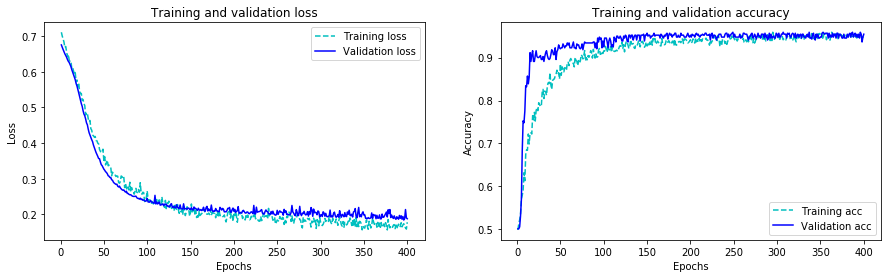

In [36]:
show_result(history)

In [37]:
evaluation_report(network_1,X_train,y_train)

[[485  30]
 [  0 514]]
             precision    recall  f1-score   support

          0       1.00      0.94      0.97       515
          1       0.94      1.00      0.97       514

avg / total       0.97      0.97      0.97      1029

Loss: 0.12809144475644832 Accuracy: 0.9708454810495627


array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [38]:
evaluation_report(network_1,X_test,y_test)

[[272  19]
 [  0  29]]
             precision    recall  f1-score   support

          0       1.00      0.93      0.97       291
          1       0.60      1.00      0.75        29

avg / total       0.96      0.94      0.95       320

Loss: 0.16649251505732537 Accuracy: 0.940625


array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

#### Logistic Regression Result

In [39]:
yhat_train_log = lr.predict(X_train) #predict the our model using the training data

In [40]:
print(classification_report(y_train, yhat_train_log, target_names =
['True','False'])) #show the performance report of model using the training predictor

             precision    recall  f1-score   support

       True       1.00      0.89      0.94       515
      False       0.90      1.00      0.95       514

avg / total       0.95      0.94      0.94      1029



In [41]:
yhat_test_log = lr.predict(X_test) #predict the our model using the training data

In [42]:
print(classification_report(y_test, yhat_test_log, target_names =
['True','False'])) #show the performance report of model using the training predictor

             precision    recall  f1-score   support

       True       1.00      0.88      0.94       291
      False       0.45      1.00      0.62        29

avg / total       0.95      0.89      0.91       320



## 5. Play with Model prediction

In [43]:
#Show all legendary
for i in range(320):
    if y_test.iloc[[i]].values==[True]:
        print('No in test: %d                   Column in data no. : %s'%(i,y_test.iloc[[i]]))

No in test: 6                   Column in data no. : 540    1
Name: Legendary, dtype: int64
No in test: 7                   Column in data no. : 430    1
Name: Legendary, dtype: int64
No in test: 14                   Column in data no. : 703    1
Name: Legendary, dtype: int64
No in test: 21                   Column in data no. : 537    1
Name: Legendary, dtype: int64
No in test: 24                   Column in data no. : 708    1
Name: Legendary, dtype: int64
No in test: 51                   Column in data no. : 538    1
Name: Legendary, dtype: int64
No in test: 65                   Column in data no. : 262    1
Name: Legendary, dtype: int64
No in test: 95                   Column in data no. : 539    1
Name: Legendary, dtype: int64
No in test: 118                   Column in data no. : 709    1
Name: Legendary, dtype: int64
No in test: 125                   Column in data no. : 550    1
Name: Legendary, dtype: int64
No in test: 127                   Column in data no. : 415    1
Name: 

In [44]:
#Show non-legendary for test
for i in range(20):
    if y_test.iloc[[i]].values == 0:
        print('No in test: %d                   Column in data no. : %s'%(i,y_test.iloc[[i]]))

No in test: 0                   Column in data no. : 8    0
Name: Legendary, dtype: int64
No in test: 1                   Column in data no. : 510    0
Name: Legendary, dtype: int64
No in test: 2                   Column in data no. : 175    0
Name: Legendary, dtype: int64
No in test: 3                   Column in data no. : 735    0
Name: Legendary, dtype: int64
No in test: 4                   Column in data no. : 242    0
Name: Legendary, dtype: int64
No in test: 5                   Column in data no. : 764    0
Name: Legendary, dtype: int64
No in test: 8                   Column in data no. : 84    0
Name: Legendary, dtype: int64
No in test: 9                   Column in data no. : 642    0
Name: Legendary, dtype: int64
No in test: 10                   Column in data no. : 255    0
Name: Legendary, dtype: int64
No in test: 11                   Column in data no. : 111    0
Name: Legendary, dtype: int64
No in test: 12                   Column in data no. : 289    0
Name: Legendary, d

In [48]:
pred_class = network_1.predict(X_test.iloc[[229]])
print ('False'+'        '+'True')
print(pred_class)

False        True
[[0.00624051 0.99375945]]


In [49]:
pred_class = lr.predict(X_test.iloc[[229]])
print ('Result')
print(pred_class)

Result
[1]


In [51]:
poke.iloc[[792]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
792,716,Xerneas,Fairy,NaN,680,126,131,95,131,98,99,6,True
